## Redes Neurais Artificiais 2020.1

**Disciplina**: Redes Neurais Artificiais 2020.1  
**Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
**Github**: http://github.com/elloa  
**Dupla**:
  - Dayvson dos Santos Silva<br/>
    **Email**: ddss.snf19@uea.edu.br<br/>
    **GitHub**: https://github.com/userddssilva<br/>
  - Hiago Oliveira de Jesus<br/>
    **Email**: hodj.lic@uea.edu.br<br/>
    **GitHub**: https://github.com/HiagoOliver<br/>        

Levando em conta a base de dados **_Forest Cover Type_**, esta terceira parte do Projeto Prático 3 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

### Importando as bibliotecas

In [125]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, plot_confusion_matrix

### Funções auxiliares

In [85]:
def _columns():
    return list (database.columns)

In [86]:
def _iloc(start_col, end_col):
    return database.iloc[:, start_col:end_col]

In [87]:
database_columns = lambda: pd.DataFrame(_columns(), columns=['Atributos']).T

## Testando Redes Neurais sem os Atributos Categórios

1. Abra a base de dados em questão
2. Elimine todas as colunas relativas aos atributos categóricos
3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X
4. Efetue uma partição holdout 70/30 com o sklearn, distribuindo os exemplos de maneira aleatória
5. Efetue o escalonamento dos atributos




### 1. Abra a base de dados em questão




#### Leitura da base de dados

In [88]:
database = pd.read_csv('database/covtype.csv')

### 2. Elimine todas as colunas relativas aos atributos categóricos


#### Colunas da base de dados anterior a eliminação dos atributos categóricos

In [89]:
database_columns()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
Atributos,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type


Os nomes das colunas que representam valores categóricos possuem como substring "Wilderness_Area" ou "Soil_Type". As expressões regulares foram utilizadas para seleção das colunas a serem eliminadas.  


In [90]:
for column in _columns():
    match = re.search('^Soil_Type\d{1,2}$|^Wilderness_Area\d$', column)
    if match:
        database.drop(columns=column, axis=1, inplace=True)    

#### Colunas da base de dados posterior a eliminação dos atributos categóricos

In [91]:
database_columns()

,0,1,2,3,4,5,6,7,8,9,10
Atributos,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type


### 3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X


#### Alocando o atributo alvo na variável y

In [92]:
y = _iloc(10,11)

**Atributo alvo**

In [93]:
list (y.columns)

['Cover_Type']

#### Alocando os atributos preditores na variável X

In [94]:
X = _iloc(0,10)

**Atributos preditores**

In [95]:
X.columns.tolist()

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points']

### 4. Efetue uma partição holdout 70/30 com o sklearn, distribuindo os exemplos de maneira aleatória

#### Particionando a base de dados em 70% para treinamento e 30% para teste

In [96]:
def holdout(X, y, shuffle=False):
    return train_test_split(X, y, test_size=0.30, shuffle=shuffle)

In [97]:
X_train, X_test, y_train, y_test = holdout(X, y)

A base de dados contém 581012 instâncias, das quais 406708 instâncias representam 70% dos dados e 174304 instâncias caracterizam 30% dos dados.

In [98]:
tamanho = database.__len__()
setenta, trinta = int(tamanho * 0.7), int(tamanho * 0.3)
pd.DataFrame([tamanho,setenta,trinta],['100%','70%','30%'],['Instâncias'])

,Instâncias
100%,581012
70%,406708
30%,174303


### Escalonando os atributos

O treinamento de uma rede neural artificial é mais eficiente quando os valores que lhes são fornecidos como entrada são pequenos, pois isto favorece a convergência. Isto é feito escalonando-se todos os atributos para o intervalo [0,1], mas precisa ser feito de maneira cautelosa, para que informações do conjunto de teste não sejam fornecidas no treinamento.

Há duas estratégias para tal escalonamento: normalização e padronização. Ambas possuem características particulares, vantagens e limitações, como é possível ver aqui: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/


No nosso caso, vamos usar a padronização. Assim, com os atributos preditores do treinamento, isto é, X_train, deve-se subtrair a média e dividir pelo desvio padrão:

X_train_std = (X_train - np.mean(X_train))/np.std(X_train)

Em seguida, o mesmo deve ser feito com os atributos preditores do conjunto de testes, mas com padronização relativa ao conjunto de treinamento:

X_test_std = (X_test - np.mean(X_train))/np.std(X_train)

Se todo o conjunto X for utilizado na padronização, a rede neural receberá informações do conjunto de teste por meio da média e variância utilizada para preparar os dados de treinamento, o que não é desejável.

### 5. Efetue o escalonamento dos atributos

In [99]:
def escalonamento(X_train, X_test):
    mean = X_train.mean() 
    std = X_train.std()   
    
    train = (X_train - mean) / std
    test = (X_test - mean) / std

    return (train, test)

#### Escalonando os atributos preditores do conjunto treinamento e teste

In [100]:
X_train_std, X_test_std = escalonamento(X_train, X_test)

### Continuando

6. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios  
    6.1 Utilize a função de ativação ReLU  
    6.2 Utilize o solver Adam    
    6.3 Imprima o passo a passo do treinamento    
    6.4 Utilize o número máximo de épocas igual a 300  
7. Com o modelo em questão, após o treinamento, apresente:  
    7.1 Matriz de confusão para o conjunto de teste  
    7.2 Acurácia  
    7.3 F-Score  
    7.4 Precisão  
    7.5 Revocação  
8. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 100 vezes  
    8.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
    8.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
9. Repita por 100 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  
    9.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
10. Houve influência da escolha do otimizador no desempenho da rede?

### 6. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios 



#### 6.1 Utilize a função de ativação ReLU
#### 6.2 Utilize o solver Adam

In [101]:
perceptron = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', verbose=True)

#### 6.3 Imprima o passo a passo do treinamento

In [105]:
perceptron.fit(X_train_std, y_train)

Iteration 1, loss = 0.89158207
Iteration 2, loss = 0.68736574
Iteration 3, loss = 0.66207872
Iteration 4, loss = 0.65335622
Iteration 5, loss = 0.64911891
Iteration 6, loss = 0.64630394
Iteration 7, loss = 0.64408057
Iteration 8, loss = 0.64243467
Iteration 9, loss = 0.64093251
Iteration 10, loss = 0.63960912
Iteration 11, loss = 0.63790143
Iteration 12, loss = 0.63577611
Iteration 13, loss = 0.63396682
Iteration 14, loss = 0.63287020
Iteration 15, loss = 0.63205267
Iteration 16, loss = 0.63149612
Iteration 17, loss = 0.63078185
Iteration 18, loss = 0.63026580
Iteration 19, loss = 0.62970856
Iteration 20, loss = 0.62918072
Iteration 21, loss = 0.62869429
Iteration 22, loss = 0.62842352
Iteration 23, loss = 0.62816074
Iteration 24, loss = 0.62790814
Iteration 25, loss = 0.62780646
Iteration 26, loss = 0.62754826
Iteration 27, loss = 0.62749821
Iteration 28, loss = 0.62723363
Iteration 29, loss = 0.62715997
Iteration 30, loss = 0.62694110
Iteration 31, loss = 0.62676223
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

#### Resultados do treinamento

O treinamento do neurônio Perceptron com uma única camada oculta, executou 116 iterações com uma função de perda de 0.6193.


### 7. Com o modelo em questão, após o treinamento, apresente:
#### 7.1 Matriz de confusão para o conjunto de teste

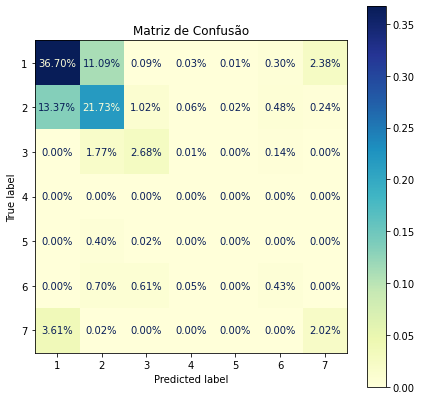

In [153]:
y_pred = perceptron.predict(X_test_std)
matriz = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(perceptron, X_test_std, y_test, ax=ax, values_format='.2%', normalize='all', cmap='YlGnBu')
plt.title('Matriz de Confusão')
plt.show()

#### 7.2 Acurácia

In [22]:
acuracia = accuracy_score(y_test, y_pred)

#### Visualizando a acurácia

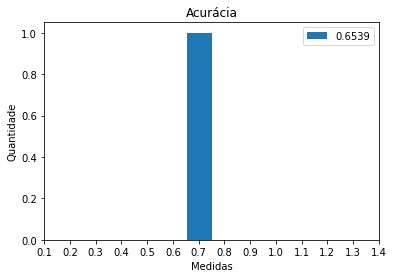

In [23]:
plt.hist([acuracia], label=np.round(acuracia, 4))
plt.title('Acurácia'), plt.xlabel('Medidas'), plt.ylabel('Quantidade')
plt.xticks(np.arange(0.1, 1.5, 0.1))
plt.legend()
plt.show()

#### 7.3 F-Score

In [24]:
fscore = f1_score(y_test, y_pred, average=None)

#### Visualizando o F-Score

In [25]:
data = np.round(fscore, 4)
labels = pd.DataFrame(data, columns=['Score'])

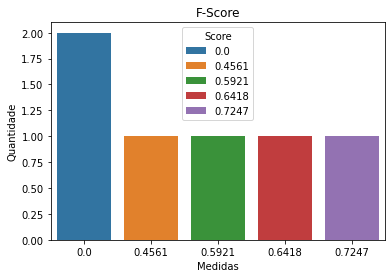

In [26]:
sns.countplot(data, hue=labels['Score'], dodge=False)
plt.title('F-Score'), plt.xlabel('Medidas'), plt.ylabel('Quantidade')
plt.show()

#### 7.4 Precisão

In [27]:
precisao = precision_score(y_test, y_pred, average=None)

#### Visualizando a precisão

In [28]:
data = np.round(precisao, 4)
labels = pd.DataFrame(data, columns=['Precision'])

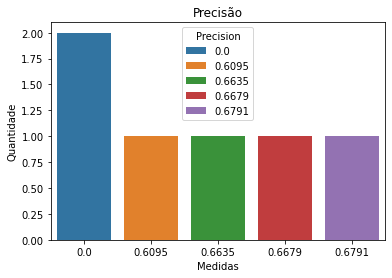

In [29]:
sns.countplot(data, hue=labels['Precision'], dodge=False)
plt.title('Precisão'), plt.xlabel('Medidas'), plt.ylabel('Quantidade')
plt.show()

#### 7.5 Revocação

In [30]:
revocacao = recall_score(y_test, y_pred, average=None)

#### Visualizando a revocação

In [31]:
data = np.round(precisao, 4)
labels = pd.DataFrame(data, columns=['Recall'])

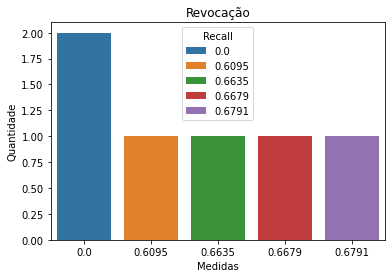

In [32]:
sns.countplot(data, hue=labels['Recall'], dodge=False)
plt.title('Revocação')
plt.xlabel('Medidas')
plt.ylabel('Quantidade')
plt.show()

#### Visualizando as métricas de desempenho

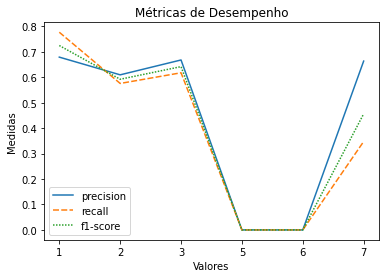

In [33]:
data = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).drop('support').iloc[:,:6]
sns.lineplot(data=data.T)
plt.title('Métricas de Desempenho'), plt.xlabel('Valores'), plt.ylabel('Medidas')
plt.show()

### 8. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 100 vezes  
   

 #### 8.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
   

In [34]:
medidas = {'acuracias':[], 'fscores':[]}

for i in range(10):
    print(i)
    X_train, X_test, y_train, y_test = holdout(X, y)
    X_train_std, X_test_std = escalonamento(X_train, X_test)
    perceptron100 = MLPClassifier(hidden_layer_sizes=(1,10), activation='relu', solver='adam', verbose=False, shuffle=True)
    perceptron100.fit(X_train_std, y_train)

    y_pred = perceptron100.predict(X_train_std)

    medidas['acuracias'].append(accuracy_score(y_train, y_pred))
    medidas['fscores'].append(f1_score(y_train, y_pred, average='macro'))


0
1
2
3
4
5
6
7
8
9


 #### 8.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  

In [35]:
import statistics as _

acuracia_mean = _.mean(medidas['acuracias'])
fscore_mean = _.mean(medidas['fscores'])

acuracia_std = _.pstdev(medidas['acuracias'])
fscore_std = _.pstdev(medidas['fscores'])

In [36]:
def mean_std(data):
    return (_.mean(data), _.pstdev(data))

In [37]:
acuracia_mean, acuracia_std = mean_std(medidas['acuracias'])
fscore_mean, fscore_std = mean_std(medidas['fscores'])

#### Visualizando os resultados

#### 9. Repita por 100 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  

In [38]:
medidas = {'acuracias':[], 'fscores':[]}

for i in range(10):
    print(i)
    X_train, X_test, y_train, y_test = holdout(X, y)
    X_train_std, X_test_std = escalonamento(X_train, X_test)
    perceptron100 = MLPClassifier(hidden_layer_sizes=(1,10), activation='relu', solver='sgd', verbose=False, shuffle=True)
    perceptron100.fit(X_train_std, y_train)

    y_pred = perceptron100.predict(X_train_std)

    medidas['acuracias'].append(accuracy_score(y_train, y_pred))
    medidas['fscores'].append(f1_score(y_train, y_pred, average='macro'))


0
1
2
3
4
5
6
7
8
9


#### 9.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  

In [39]:
acuracia_mean, acuracia_std = mean_std(medidas['acuracias'])
fscore_mean, fscore_std = mean_std(medidas['fscores'])

#### Visualizando os resultados

#### 10. Houve influência da escolha do otimizador no desempenho da rede?

## Discussão

Nos passos anteriores, você avaliou o desempenho de uma única rede neural que contém os seguintes parâmetros: uma única camada oculta com 10 neurônios e função de ativação ReLU. O otimizador utilizado, quer seja SGD ou ADAM, trata-se do algoritmo para aproximar o gradiente do erro. Neste sentido, a escolha do otimizador é um hiperparâmetro, pois diz respeito a como a rede neural definida previamente atuará "em tempo de execução"  durante o processo de treinamento. Também são hiperparâmetros a quantidade de épocas, a taxa de aprendizado inicial, dentre outros.

Cabe alientar também que você efetuou o treinamento desta rede por 100 vezes e apresentou os resultados em termos de média +- desvio padrão. Lembre-se que em uma rede neural há a inicialização aleatória de pesos e, em consequência, o desempenho delas está sujeito à uma flutuação estocástica. A execução destas múltiplas vezes faz com que eliminemos algum viés introduzido por uma boa ou má "sorte" na escolha de pesos no caso de uma única execução.

Você também aprendeu uma estratégia para escalonar os atributos para uma melhor convergência da rede. Utilize-a em todos os treinamentos e testes propostos a seguir.

## Propondo Novas Arquiteturas

Variando  os parâmetros (uma ou duas camadas ocultas, com diferente números de neurônios em cada uma delas e a função de ativação) e o hiperparâmetros solver (Adam ou SGD) e o número de épocas (100,150 e 200), atenda ao que se pede:

1. Proponha 10 arquiteturas distintas de RNAs para o problema em questão, à sua escolha
2. Avalie cada uma das arquiteturas perante todos os hiperparâmetros apresentados por 100 vezes
3. Como resultado da avaliação, apresente:  
    3.1 Top-3 melhores redes no tocante à F-Score e Acurácia  
    3.2 Repetição em que houve o melhor desempenho de cada uma dessas redes: ilustre tp, tf, fp e fn  

## Estimando o número de neurônios

Um dos problemas de pesquisa com redes neurais artificiais consiste na determinação do número de neurônios em sua arquitetura. Embora não seja possível definir a priori qual rede neural é adequada para um problema, pois isto só é possível mediante uma busca exaustiva, há regras na literatura que sugerem o número de neurônios escondidos, tal como a regra da Pirâmide Geométrica, dada a seguir:

$$N_h = \alpha \cdot \sqrt{N_i \cdot N_o},$$

em que $N_h$ é o número de neurônios ocultos (a serem distribuídos em uma ou duas camadas ocultas), $N_i$ é o número de neurônios na camada de entrada e $N_o$ é o número de neurônios na camada de saída. 

1. Consulte a documentação da classe MLPClassifier (disponível em https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) e obtenha os valores de $N_i$ e $N_h$.
2. Teste os valores de $\alpha$ como sendo iguais a $0.5$, $2$ e $3$.
3. Proponha pelo menos 30 redes neurais segundo a regra da pirâmide geométrica e teste-as nos mesmos termos estabelecidos anterioremente  (solver, épocas, etc.)  
    3.1 Apresente as top-3 melhores redes no tocante à F-Score e Acurácia  

## Testando as Redes Neurais com Atributos Categóricos

1. Considere as 6 redes neurais obtidas nos dois top-3 anteriores (arquiteturas próprias e regra da pirâmide geométrica)
2. Com todos os atributos preditores da base de dados original, incluindo os categóricos, treine e teste estas mesmas redes por 100 repetições  
    2.1 Considere o melhor otimizador para cada uma delas  
    2.2 Faça uso de 200 épocas para treinamento  
    2.2 Apresente os resultados de acurácia e F-Score em termos da média +- dp para cada arquitetura
3. Apresente o gráfico boxplot para o F-Score das 6 arquiteturas perante as 100 repetições

## Considerações Parciais

1. É possível identificar uma rede com desempenho superior às demais?
2. Qual estratégia mostrou-se mais producente para a obtenção de boas arquiteturas (Estratégia Própria ou Pirâmide Geométrica)? Por quê?
3. Considerar os atributos categóricos trouxe melhorias? Justifique.
4. Um número maior de épocas trouxe melhorias?
5. Qual a maior dificuldade de resolução do problema proposto perante as RNAs?